In [27]:
using Plots

In [ ]:
n = 200
a = collect(range(0, stop=4 * pi, length=Int(n/2)))
u = append!(a .* cos.(a), (a .+ pi) .* cos.(a)) + rand(n, 1)
v = append!(a .* sin.(a), (a .+ pi) .* sin.(a)) + rand(n, 1)
x = [u v]
y = append!(reshape(ones(1, Int(n/2)), (100,)), reshape(-ones(1, Int(n/2)), (100,)))

In [2]:
mutable struct SVMResult
    n::Int64
    epsilon::Float64
    h::Float64
    C::Float64
    theta::VecOrMat{Float64}
    x::VecOrMat{Float64}
    y::VecOrMat{Float64}
    k::Matrix{Float64}
    converged::Bool
end

In [3]:
function SVM(
    x::Matrix{T}, 
    y::VecOrMat{T}, 
    C::Float64, 
    h::Float64;
    epsilon::Float64=0.01, 
    maxiter::Int64=10000, 
    tol::Float64=1e-6) where T<:AbstractFloat

    n = Int(length(x) / 2)
    @assert n == length(y)
    xx = x[:, 1]
    xy = x[:, 2]
    xx2 = xx .^ 2
    xy2 = xy .^ 2
    k = exp.(
        -(
            (repeat(xx2, 1, n) + repeat(xx2', n, 1) - 2 .* (xx * xx')) + 
            (repeat(xy2, 1, n) + repeat(xy2', n, 1) - 2 .* (xy * xy'))
        ) ./ (2 * h^2)
    )
    theta = rand(n, 1)
    converged = false
    cnt = 1
    while !converged && cnt < maxiter
        delThetaj = ifelse.(
            ones(n, 1) - (k * theta) .* y .> 0,
            - y .* k,
            0
        )
        sum_delTheta = sum(delThetaj, dims=1)'
        new_theta = theta - epsilon .* (C .* sum_delTheta + 2 .* (k * theta))
        if sqrt(sum((theta - new_theta).^2)) > tol
            theta = new_theta
            cnt += 1
        else
            theta = new_theta
            converged = true
        end
    end
    SVMResult(n, epsilon, h, C, theta, x, y, k, converged)
end

SVM (generic function with 1 method)

In [16]:
function predict(svm::SVMResult, X::VecOrMat{Float64})
    N = Int(length(X) / 2)
    XX = X[:, 1]
    XY = X[:, 2]
    xx = svm.x[:, 1]
    xy = svm.x[:, 2]
    XX2 = XX .^ 2
    XY2 = XY .^ 2
    xx2 = xx .^ 2
    xy2 = xy .^ 2
    K = exp.(
        -(
            (repeat(XX2, 1, svm.n) + repeat(xx2', N, 1) - 2 .* (XX * xx')) +
            (repeat(XY2, 1, svm.n) + repeat(xy2', N, 1) - 2 .* (XY * xy'))
        ) ./ (2 * svm.h^2)
    )
    p = K * svm.theta
end

predict (generic function with 1 method)

In [24]:
SVM(x, y, 0.1, 0.3)

SVMResult(200, 0.01, 0.3, 0.1, [0.0474182; 0.0599338; … ; -0.05; -0.05], [0.630873 0.186301; 1.06375 0.558811; … ; 15.83 -1.57431; 16.3917 0.964875], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [1.0 0.163342 … 0.0 0.0; 0.163342 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 4.81384e-17; 0.0 0.0 … 4.81384e-17 1.0], false)

In [25]:
svm = ans

SVMResult(200, 0.01, 0.3, 0.1, [0.0474182; 0.0599338; … ; -0.05; -0.05], [0.630873 0.186301; 1.06375 0.558811; … ; 15.83 -1.57431; 16.3917 0.964875], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], [1.0 0.163342 … 0.0 0.0; 0.163342 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 4.81384e-17; 0.0 0.0 … 4.81384e-17 1.0], false)

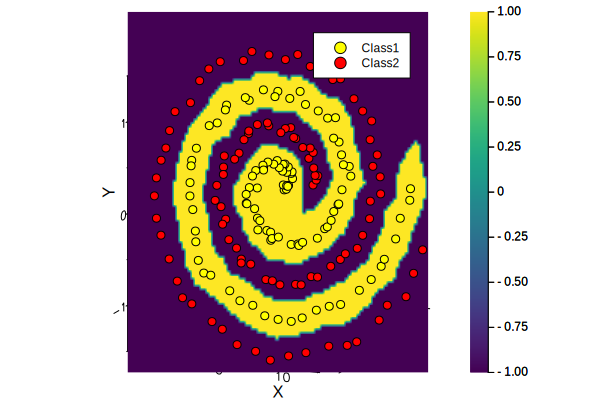

In [65]:
m = 100
X = collect(range(-15, stop=15, length=m))
X2 = X .^ 2
U=exp.(-(repeat(u.^2,1,m)+repeat(X2',n,1)-2 .* (u*X'))/ (2 * svm.h^2))
V=exp.(-(repeat(v.^2,1,m)+repeat(X2',n,1)-2 .* (v*X'))/ (2 * svm.h^2))
p = contour(X, X, sign.(V' * (U .* repeat(svm.theta, 1, m))), 
    fill=true,
    fillcolor=:viridis,
    fillalpha=0.1,
    xlabel="X",
    ylabel="Y",
    xlims=(-15, 15),
    ylims=(-15, 15)
)
scatter!(p, u[1:100], v[1:100], y[1:100], color=:yellow, label="Class1", ticks=false)
scatter!(p, u[101:200], v[101:200], y[101:200], color=:red, label="Class2", ticks=false)
